# Classifying Household Income from US Census Data
### Some fun with boosted classification algorithms

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import *
from sklearn.metrics import accuracy_score

This notebook contains a predictive modeling exercise of the data presented in the ['Adult Census Income'](https://www.kaggle.com/uciml/adult-census-income/home) Kaggle Challenge. The data supplied for this challenge data was extracted from the 1994 census and contains aggregated demographic information (associated with a class 'weight') for US households. The prediction task is a binary classification to determine if a given household's annual income is above $50K a year.

The approach of the analysis in this notebook is as follows:

1. Initial exploratory analysis
2. Initial assessment of ML classification models
    - Quality was assessed by calculating precision/recall scores and comparing ROC curves
3. Recursive feature selection (RFE) using estimator shortlist to rank feature importance
4. Re-assess short-listed models with new feature set
5. Perform parameter tuning using GridSearchCV on top 2 models
6. Identify best model

The best model identified in this analysis was a GradientBoostingClassifier with an accuracy of 87.4%.

## 0. Load and Format Data

In [3]:
census = pd.DataFrame.from_csv('adult.csv', index_col=None)

In [4]:
# replace '.' in heading columns

census.columns = census.columns.str.replace(".", "_")

In [5]:
# re-format income values; 1 = greater than 50k, 0 = less than 50k

census.income = census.income.str.replace('>50K', '1')
census.income = census.income.str.replace('<=50K', '0')
census.income = census.income.astype('int64')

In [6]:
# replace '?'s in data with NaNs

census = census.replace(to_replace='?',value=np.nan)

In [7]:
# fill in null birth country information with 'United-States'; it is the most common 
census.native_country = census.native_country.fillna('United-States')

In [8]:
len(census)

32561

### 1. Initial Exploratory Analysis

In [9]:
#identify data types of columns 

g = census.columns.to_series().groupby(census.dtypes).groups
print(g)

{dtype('int64'): Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income'],
      dtype='object'), dtype('O'): Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='object')}


In [10]:
census.fnlwgt[0]

77053

In [11]:
census.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [12]:
# define numeric and categorical variables

num_var = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income']

cat_var = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country']

In [129]:
len(census.columns)

15

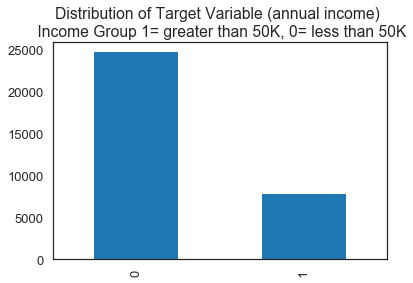

In [13]:
# count target variable

sns.set_context("talk")
sns.set_style("white")

census['income'].value_counts().plot.bar()
plt.title('Distribution of Target Variable (annual income) \n Income Group 1= greater than 50K, 0= less than 50K')
plt.show()

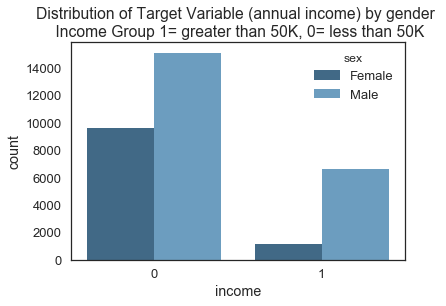

In [14]:
# count target variable
sns.set_context("talk")
sns.set_style("white")

sns.countplot(x="income", hue="sex", data=census, palette="Blues_d")
plt.title('Distribution of Target Variable (annual income) by gender \n Income Group 1= greater than 50K, 0= less than 50K')
plt.show()

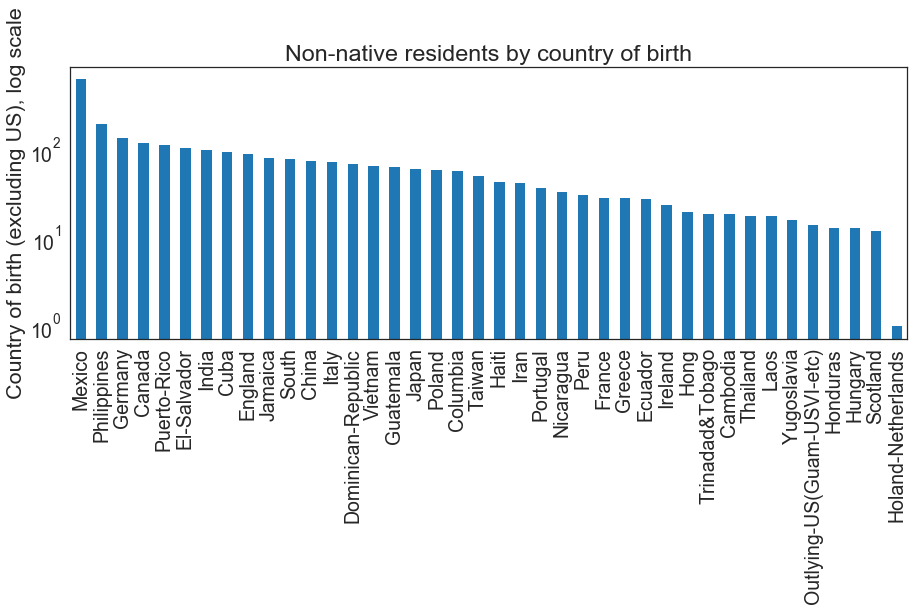

In [15]:
# plotting country of birth

sns.set_context("talk", font_scale=1.5)
sns.set_style("white")
plt.figure(figsize=(15,5))
census[census.native_country != 'United-States']['native_country'].value_counts().plot.bar()
plt.yscale('log') # log scale because the prevalence of some countries (Mexico) mask trends
plt.ylabel('Country of birth (excluding US), log scale')
plt.title('Non-native residents by country of birth')
plt.show()

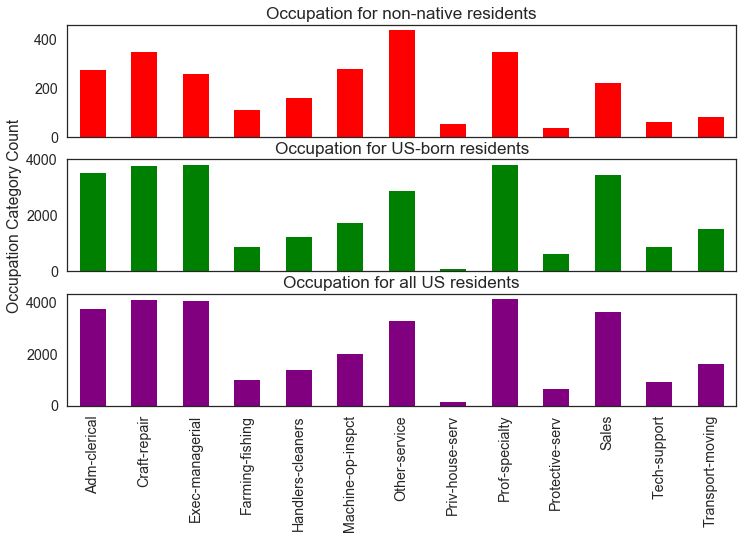

In [16]:
# plotting occupation for non-native residents

sns.set_context("talk", font_scale=1.1)
sns.set_style("white")
fig = plt.figure(figsize=[12, 7])

fig.add_subplot(3,1,1)
census[(census.native_country != 'United-States') & 
       (census.occupation != 'Armed-Forces')]['occupation'].value_counts().sort_index().plot.bar(
    color='red',sort_columns=True)
#plt.ylabel('Occupation for non-native residents')
plt.xticks([])
plt.title('Occupation for non-native residents')

fig.add_subplot(3,1,2)
census[(census.native_country == 'United-States') & 
       (census.occupation != 'Armed-Forces')]['occupation'].value_counts().sort_index().plot.bar(color = 'green',sort_columns=True)
plt.ylabel('Occupation Category Count')
plt.xticks([])
plt.title('Occupation for US-born residents')

fig.add_subplot(3,1,3)
census[census.occupation!='Armed-Forces']['occupation'].value_counts().sort_index().plot.bar(color = 'purple',sort_columns=True)
#plt.ylabel('Occupation for all residents')
plt.title('Occupation for all US residents')

plt.show()

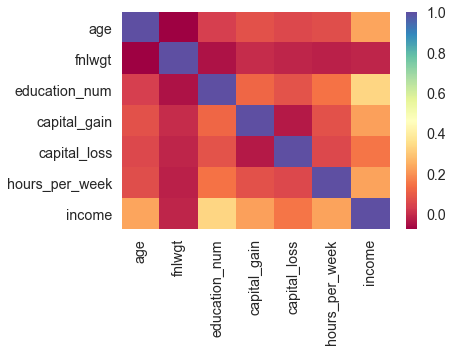

In [17]:
# Correlation matrix between numerical values
g = sns.heatmap(census[num_var].corr(), cmap = "Spectral")
plt.show()

In [18]:
# calc correlation coefficient
census[num_var].corr(method='pearson')

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education_num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital_gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital_loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours_per_week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


Some small and medium correlations in the numeric data

Small correlations: 
education and capital_gain (0.122)
education and hours_per_week (0.148)
age and income (0.234)
capital_gain and income(0.223)
capital_lost and income (0.151)
income and hours_per_week (.230)

Medium correlation:
education and income (0.335)


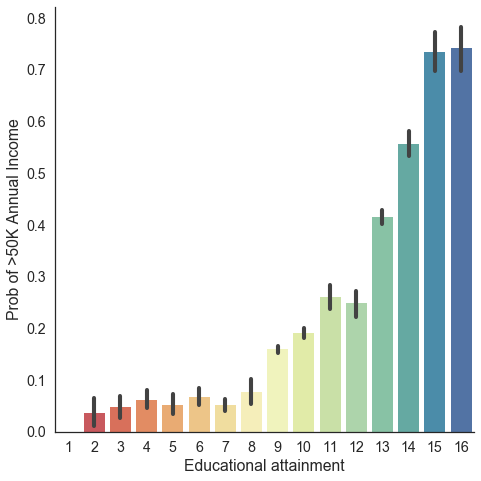

In [19]:
# Explore Education Num vs Income
g = sns.factorplot(x="education_num", y="income",data=census, kind="bar",size = 7, palette = "Spectral")
g.set_ylabels("Prob of >50K Annual Income")
g.set_ylabels("Prob of >50K Annual Income")
g.set_xlabels("Educational attainment")
plt.show()

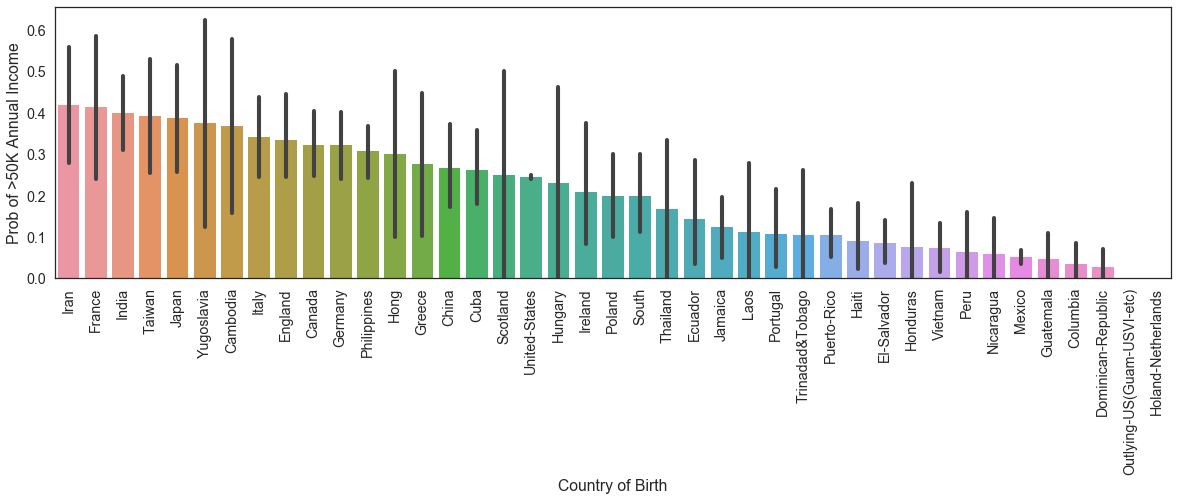

In [20]:
# Explore country of birth and probability of >50K annual income

fig = plt.figure(figsize=[20, 5])

income_prob_ranked = list(((census.groupby('native_country')['income'].mean()).sort_values(ascending=False)).index)
g = sns.barplot(x="native_country",y="income",data=census, order =income_prob_ranked)
g.set_ylabel("Prob of >50K Annual Income")
g.set_xlabel('Country of Birth')
plt.xticks(rotation=90)

plt.show()

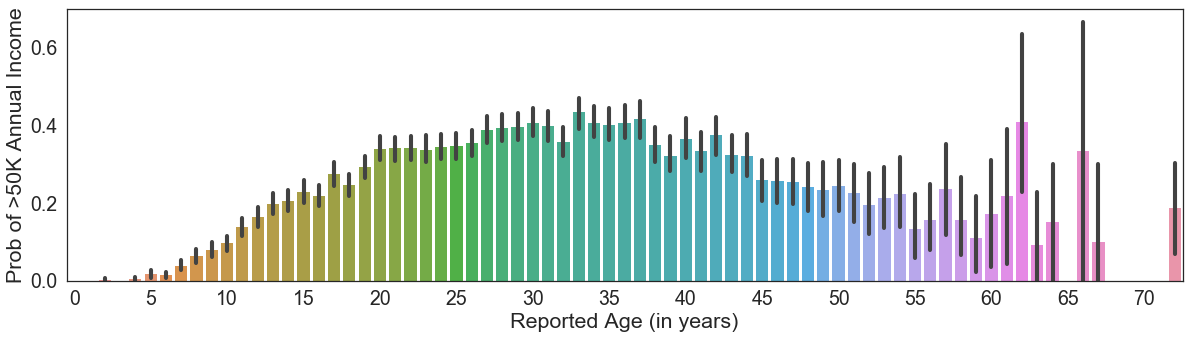

In [21]:
# Explore country of birth and probability of >50K annual income

import matplotlib.ticker as ticker
fig = plt.figure(figsize=[20, 5])
sns.set_context("talk", font_scale=1.5)


g = sns.barplot(x="age",y="income",data=census)
g.set_ylabel("Prob of >50K Annual Income")
g.set_xlabel('Reported Age (in years)')
g.xaxis.set_major_locator(ticker.MultipleLocator(5))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

### Prepare the data for modeling

#### Remove unwanted varaibles and create dummies for categorical variables

In [22]:
# create copy of df for modification
census_copy = census.copy(deep=True)

In [23]:
census_copy.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [24]:
# omit 'fnlwgt' since it is a weight metric, not technically demographic information
# omit 'education' since we have this information as 'education_num'

census_copy = census_copy[['age', 'workclass', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income']]

In [25]:
# create new list of categorical variables; categorical variables will have to be converted to dummies
new_cat_var = []
for var in cat_var:
    if var in census_copy.columns:
        new_cat_var.append(var)

In [26]:
# create dummy variables for categorical data and remove categorical columns
census_copy = pd.concat([pd.get_dummies(census_copy[new_cat_var]), census_copy.drop(census_copy[new_cat_var], axis=1)], axis=1)

In [32]:
# create list of features names to rank importance during feature selection (below)
feature_names = list(census_copy.columns)[:-1]

In [34]:
len(feature_names)

88

#### Split data into features and target

In [39]:
# create arrays of data and target

array = census_copy.values
X = array[:,0:88] # for initial modeling include all features
y = array[:,88] # target is income group

## 2. Initial assessment of ML classification models

### Fit models and evaluate with classification report

After defining the intial set of data features and the prediction target (i.e. income), I calcuated the rate of success for a 'null' model. How frequently would a model be correct if it **always** predicted a target of 0 (i.e. always predicted an income of below $50K)? 

In [41]:
# calculating the baseline of the positive case

print(1-(census.income.sum()) / (census.income.count()))

0.759190442554


An 'always 0' model would be correct 75.6% of the time. Now let's do some modeling to see if we can beat this. I started by assessing a number of classifier algorithms. I examined the precision, recall, and ROC curves of the algorithms in the list of estimators.

In [42]:
# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC

estimator_list = [LogisticRegression, RandomForestClassifier, SGDClassifier, lgb.LGBMClassifier, 
                  ExtraTreesClassifier, GradientBoostingClassifier, SVC, LinearSVC]

#### Precision and recall of estimators using default settings

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

# Splits defined X and y arrays by validation size, fits the model (estimator) and 
# calculates classification report for assessment
# Here X is census feature data and y is income class(above 50K = 1, below 50K = 0)

def split_fit_model(X, y, validation_size, estimator):

    X_train, X_validation, y_train, y_validation = train_test_split(X,y,
    test_size=validation_size,random_state=42)

    clf = estimator(random_state=42)

    clf.fit(X_train, y_train)
    
    y_val_pred = clf.predict(X_validation)

    report = classification_report(y_validation, y_val_pred)
    score = precision_score(y_validation, y_val_pred)
    
    print('The classification report of {}, default params \n'.format(estimator.__name__))
    print(report)

    # return fitted classifier and precision and accuracy scores for later
    return clf, precision_score(y_validation, y_val_pred), recall_score(y_validation, y_val_pred)

In [44]:
# save classifier precision and recall in dictionaries for assessment later

clf_precision_scores = {}
clf_recall_scores = {}

#run split_fit for each model to assess performance
for estimator in estimator_list:
    report = split_fit_model(X, y, 0.3, estimator)
    clf_precision_scores[estimator.__name__] = report[1]
    clf_recall_scores[estimator.__name__] = report[2]

The classification report of LogisticRegression, default params 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90      7429
          1       0.73      0.58      0.65      2340

avg / total       0.84      0.85      0.84      9769

The classification report of RandomForestClassifier, default params 

             precision    recall  f1-score   support

          0       0.88      0.93      0.90      7429
          1       0.72      0.60      0.65      2340

avg / total       0.84      0.85      0.84      9769

The classification report of SGDClassifier, default params 

             precision    recall  f1-score   support

          0       0.93      0.75      0.83      7429
          1       0.51      0.83      0.64      2340

avg / total       0.83      0.77      0.79      9769

The classification report of LGBMClassifier, default params 

             precision    recall  f1-score   support

          0       0.89      0.95      0.92

In [45]:
clf_precision_scores, clf_recall_scores

({'ExtraTreesClassifier': 0.67082035306334376,
  'GradientBoostingClassifier': 0.7990654205607477,
  'LGBMClassifier': 0.78727841501564133,
  'LinearSVC': 0.72088546679499521,
  'LogisticRegression': 0.73474945533769065,
  'RandomForestClassifier': 0.72308488612836441,
  'SGDClassifier': 0.51455026455026454,
  'SVC': 0.82787958115183247},
 {'ExtraTreesClassifier': 0.55213675213675217,
  'GradientBoostingClassifier': 0.58461538461538465,
  'LGBMClassifier': 0.64529914529914534,
  'LinearSVC': 0.32008547008547006,
  'LogisticRegression': 0.57649572649572645,
  'RandomForestClassifier': 0.597008547008547,
  'SGDClassifier': 0.83119658119658124,
  'SVC': 0.54059829059829057})

#### ROC (receiver operating characteristic) curve of  estimators (default settings)

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculates the false positive rate and true positive rate of estimators
# use .predict_proba or decision_function depending on estimator

def calc_fpr_trp(X, y, validation_size, estimator):

    X_train, X_validation, y_train, y_validation = train_test_split(X,y,
    test_size=validation_size,random_state=42)

    clf = estimator(random_state=42)

    clf.fit(X_train, y_train)
    
    try: # for classes with a predict_probab method
        y_scores = clf.predict_proba(X_validation)[:, 1] # score = proba of positive class
        fpr, tpr, thresholds = roc_curve(y_validation, y_scores)
        
    except AttributeError: # for classes without a decision_function method (loss = hinge)
        score_roc = clf.decision_function(X_validation)
        fpr, tpr, thresholds = roc_curve(y_validation, score_roc)
        
    return(estimator.__name__,fpr, tpr)

In [47]:
# plot roc_curve give the fpr and tpr values

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

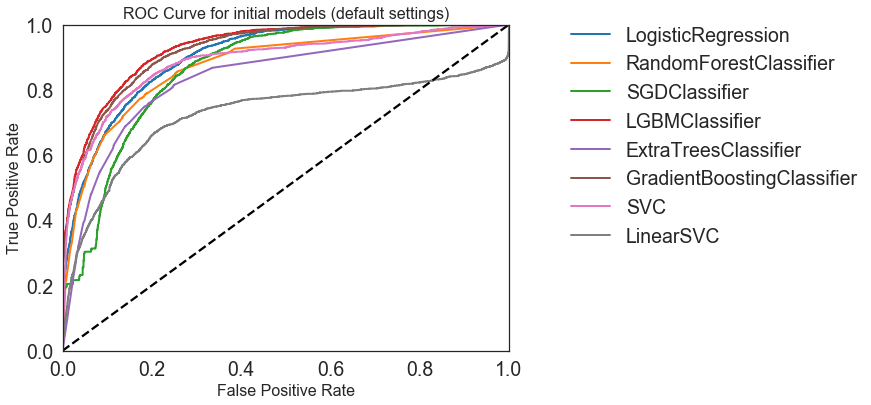

In [48]:
plt.figure(figsize=(8, 6))
for estimator in estimator_list:
    roc_vals = calc_fpr_trp(X,y,0.3,estimator)
    fpr = roc_vals[1]
    tpr = roc_vals[2]
    plot_roc_curve(fpr, tpr, label=roc_vals[0])

plt.title('ROC Curve for initial models (default settings)', fontsize=16)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

The initial exploration of models suggests that 1) precision is highest for LGBMClassifier (0.787) and SVC (0.828), 2) recall is highest for LGBMClassifier (0.645) and SGDClassifier (0.831), and 3) the ROC curve of the LGBMClassifier and GradientBoostingClassifier look nearly equivalently good. At this point I need to think about what I want to do with my model. 

Let's say I want to target households making more than \$50K annual for a political canvassing campaign. Sending people door to door is expensive and time consuming, so I'd select a model with high precision (SVC or LGBMClassifier) and a low rate of false positives. If, on the other hand, I'm mailing out cheap fliers and want to capture the broadest possible swath of households making more than \$50K annually, I'd select a model with high recall (LGBMClassifier or SGDClassifier).

For the sake of this analysis, I'll assess feature selection and grid search with an estimator shortlist that includes the 4 top models: LGBMClassifier, SVC, SGDClassifier, and the GradientBoostingClassifier.

## 3. Recursive feature selection (RFE) using estimator shortlist to rank feature importance

In [49]:
def rank_features(X, y, estimator, feature_list):
    est = estimator()
    rfe = RFE(est)
    rfe = rfe.fit(X,y)
    keys = feature_list
    values = rfe.ranking_
    dictionary = dict(zip(keys, values))
    scores = pd.DataFrame.from_dict(dictionary, orient='index')
    scores.columns = ['{}_rank'.format(estimator.__name__)]
    return(scores)

In [50]:
# removed SVC because training SVC models takes a very long time 
estimator_shortlist = [lgb.LGBMClassifier, SGDClassifier, GradientBoostingClassifier]

In [51]:
# use RFE to score the important features as evaluated by the shortlisted estimators

scores_list = []

for estimator in estimator_shortlist:
    scores = rank_features(X, y, estimator, feature_names)
    scores_list.append(scores)

In [52]:
# concatenate list of scores into df with feature as index
all_feature_ranks = pd.concat(scores_list, axis=1)

After doing RFE on my shortlist of estimators, I sorted the feature rankings to identify which features were ranked highly by all of the models. Features consistantly ranked as important are likely going to be important features for building a final model, and also provide insight into the nature of the data. Features that are consistantly ranked as important are 'workclass', 'marital_status', 'occupation', 'capital_gain', 'capital_loss', 'education_num', 'hours_per_week', 'gender', and 'race'. 'Age' is ranked as important by the LGBMClassifier and GradientBoostingClassifier models. Specific 'native_country' features are important to individual models, but the overall feature doesn't provide a lot of value to these models.

Based on this assessment, I refined the feature list by removing 'native_country' from my feature list and re-assessed my estimator shortlist using precision/recall assessment and ROC curve comparisons.

In [130]:
all_feature_ranks.sort_values(by=list(all_feature_ranks.columns)).head(n=25)

,LGBMClassifier_rank,SGDClassifier_rank,GradientBoostingClassifier_rank
workclass_Federal-gov,1,1,1
workclass_Self-emp-inc,1,1,1
workclass_Self-emp-not-inc,1,1,1
marital_status_Married-AF-spouse,1,1,1
marital_status_Married-civ-spouse,1,1,1
marital_status_Never-married,1,1,1
marital_status_Widowed,1,1,1
occupation_Exec-managerial,1,1,1
occupation_Farming-fishing,1,1,1
occupation_Handlers-cleaners,1,1,1


In [55]:
# create copy of df for modification
census_copy = census.copy(deep=True)

# I'm keeping the features selected by the RFE analysis

census_copy = census_copy[['age', 'workclass', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week','income']]

# identify categorical variables
new_cat_var = []
for var in cat_var:
    if var in census_copy.columns:
        new_cat_var.append(var)

# convert categorical variables to dummy variables remove original categorical columns
census_copy = pd.concat([pd.get_dummies(census_copy[new_cat_var]), census_copy.drop(census_copy[new_cat_var], axis=1)], axis=1)

In [57]:
# list of selected veatures as identified by RFE
selected_features =  list(census_copy.columns)[:-1]

In [58]:
len(selected_features)

47

## 4. Re-assess shortlist models with new feature set

In [61]:
# create arrays of data and target

array = census_copy.values
X = array[:,0:47] # for initial modeling include all features
y = array[:,47] # target is income group

In [67]:
estimator_shortlist = [lgb.LGBMClassifier,
                       SGDClassifier,
                       GradientBoostingClassifier, 
                       SVC]

In [68]:
# calculate classifier precision and recall on new feature set

clf_precision_scores = {}
clf_recall_scores = {}

#run split_fit for each model to assess performance
for estimator in estimator_shortlist:
    report = split_fit_model(X, y, 0.3, estimator)
    clf_precision_scores[estimator.__name__] = report[1]
    clf_recall_scores[estimator.__name__] = report[2]

The classification report of LGBMClassifier, default params 

             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7429
          1       0.78      0.64      0.71      2340

avg / total       0.87      0.87      0.87      9769

The classification report of SGDClassifier, default params 

             precision    recall  f1-score   support

          0       0.98      0.57      0.72      7429
          1       0.41      0.97      0.58      2340

avg / total       0.85      0.66      0.69      9769

The classification report of GradientBoostingClassifier, default params 

             precision    recall  f1-score   support

          0       0.88      0.95      0.91      7429
          1       0.80      0.58      0.67      2340

avg / total       0.86      0.86      0.86      9769

The classification report of SVC, default params 

             precision    recall  f1-score   support

          0       0.87      0.96      0.91      7429


In [69]:
clf_precision_scores, clf_recall_scores

({'GradientBoostingClassifier': 0.79858657243816256,
  'LGBMClassifier': 0.78296988577362414,
  'SGDClassifier': 0.41291263906620462,
  'SVC': 0.8098591549295775},
 {'GradientBoostingClassifier': 0.57948717948717954,
  'LGBMClassifier': 0.64444444444444449,
  'SGDClassifier': 0.96752136752136753,
  'SVC': 0.54059829059829057})

Comparing the precision and recall scores of the shortlisted estimators before and after feature reduction, there is only a slight change in performance. A few of the estimators get slightly better but some actually get poorer. I elected to continue exploring the shortlisted models with the smaller feature set (native_country removed) that will hopefully make more robustly generalizable models, but the decrease in precision/recall upon removing these features will be considered in the tuning of the final model.

`Precision :
'GradientBoostingClassifier': 0.7990654205607477 (before)
'GradientBoostingClassifier': 0.79858657243816256 (after)
'LGBMClassifier': 0.78727841501564133 (before)
'LGBMClassifier': 0.78296988577362414 (after)
'SGDClassifier': 0.51455026455026454 (before)
'SGDClassifier': 0.41291263906620462 (after)
'SVC': 0.82787958115183247 (before)
'SVC': 0.8098591549295775 (after)`

`Recall:
'GradientBoostingClassifier': 0.58461538461538465 (before)
'GradientBoostingClassifier': 0.57948717948717954 (after)
'LGBMClassifier': 0.64529914529914534 (before)
'LGBMClassifier': 0.64444444444444449 (after)
'SGDClassifier': 0.83119658119658124 (before)
'SGDClassifier': 0.96752136752136753 (after)
'SVC': 0.54059829059829057 (before)
'SVC': 0.54059829059829057(after)`

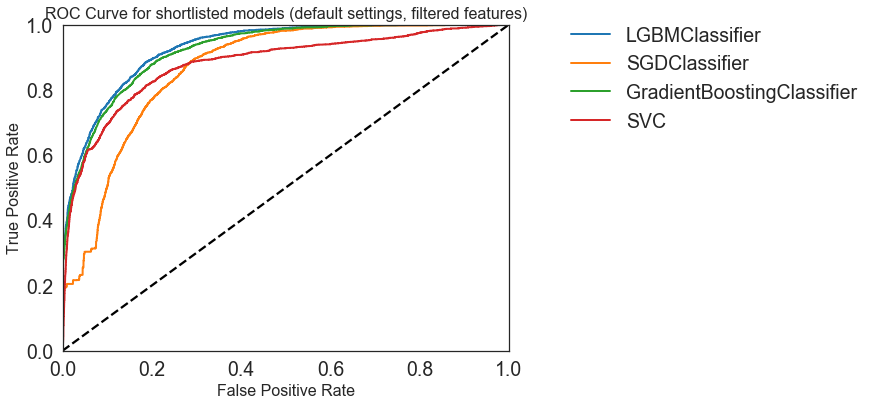

In [70]:
# plot ROC curves with reduced feature number

plt.figure(figsize=(8, 6))
for estimator in estimator_shortlist:
    roc_vals = calc_fpr_trp(X,y,0.3,estimator)
    fpr = roc_vals[1]
    tpr = roc_vals[2]
    plot_roc_curve(fpr, tpr, label=roc_vals[0])

plt.title('ROC Curve for shortlisted models (default settings, filtered features)', fontsize=16)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

Based on this analysis, the two most promissing classifiers are the GradientBoostingClassifier and the LGBMClassifier. Both of these algorithms are 'boosted' algorithms, which means they use multiple weakly-correlated features to generate strongly-correlated features. The GradientBoostingClassifier and the LGBMClassifier were selected for further tuning using GridSearchCV.

## 5a. Tuning the GradientBoostingClassifier, a verbose approach

I'll begin by tuning the hyper parameters of the GradientBoostingClassifier following the general approach outlined in this [blog post](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/). The general approach is to 1) hold learning rate constant, 2) optimize n_estimators (number of trees), 3) optimize other tree parameters, then 4) using the newly determined parameters optimize learning rate and n_estimators in a combined GridSearch. I added an additional step of doing a final combined GridSearch using a tight range of the 'optimized' parameters so that I can capture any unexpected interactions between parameters. 

This approach is more verbose code than doing a grid search over a wide range of all the parameters at once, but when reasonable parameter ranges are unknown this approach is helpful. Note, this section can be skipped to the final model cell without missing any content. 

Before I began this approach, I calcuated the precision, recall, and accuracy scores for the 'baseline' GradientBoostingClassifier, that is the classifier with default parameter settings. This provides a baseline for measuring model improvement with tuning.

In [72]:
# split data for grid search optimization

X_train, X_validation, y_train, y_validation = train_test_split(X,y,test_size=0.3,random_state=42)

In [95]:
### GBC Baseline Scores ###
clf = GradientBoostingClassifier(random_state=42)

clf.fit(X_train, y_train)
    
y_val_pred = clf.predict(X_validation)

precision = precision_score(y_validation, y_val_pred)
recall = recall_score(y_validation, y_val_pred)
accuracy = accuracy_score(y_validation, y_val_pred)
    
print('The precision_score is {}, default params'.format(precision))
print('The recall_score is {}, default params'.format(recall))
print('The accuracy_score is {}, default params'.format(accuracy))

The precision_score is 0.7985865724381626, default params
The recall_score is 0.5794871794871795, default params
The accuracy_score is 0.8642645101852799, default params


In [74]:
# start with a fixed, high learning rate 
# tuning n_estimators

clf = GradientBoostingClassifier(learning_rate=0.1, 
                                 min_samples_split=200, # should be 0.5-1% of data instances
                                 min_samples_leaf=50,
                                 max_depth=6, # based on number of observations in data
                                 max_features='sqrt',
                                 subsample=0.8,
                                 random_state=42)

param_grid = {'n_estimators':range(20,80,10)}
search = GridSearchCV(clf,param_grid, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5)

search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=200, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 80, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [75]:
print('Best parameters found by grid search are:', search.best_params_)
print('The score of the best parameter is:', search.best_score_)

Best parameters found by grid search are: {'n_estimators': 70}
The score of the best parameter is: 0.918477185673


So the optimum number of trees given a learning rate of 0.1 is n_estimators = 70. Great. Now let's tune some tree-specific parameters.

Following the approach referenced [above](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/), next I tested max_depth values of 8 to 20 in steps of 2 and min_samples_split from 200 to 700 in steps of 100.

In [80]:
# tuning tree specific parameters, max_depth and min_samples_split

clf = GradientBoostingClassifier(learning_rate=0.1, # keep at 0.1 
                                 n_estimators=70, # optimum number determined above
                                 max_features='sqrt', 
                                 subsample=0.8, 
                                 random_state=42)

param_grid2 = {'max_depth':range(8,20,2), 'min_samples_split':range(200,700,100)}

search2 = GridSearchCV(clf,param_grid2, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5, verbose=1)

search2.fit(X_train, y_train)

print('Best parameters found by grid search are:', search2.best_params_)
print('The score of the best parameter is:', search2.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  4.2min finished


Best parameters found by grid search are: {'max_depth': 16, 'min_samples_split': 400}
The score of the best parameter is: 0.923883438701


Great, so now we have that the optimum max_depth is 16, and the optimum min_samples_split is 400. Let's continue tuning the tree parameters.

In [81]:
# tuning tree specific parameters, min_samples_leaf

clf = GradientBoostingClassifier(learning_rate=0.1, # keep at 0.1 
                                 n_estimators=70, # optimum number determined above
                                 max_depth=16, # optimum number determined above
                                 min_samples_split=400, # optimum number determined above
                                 max_features='sqrt', 
                                 subsample=0.8, 
                                 random_state=42)

param_grid3 = {'min_samples_leaf':range(1,5,1)} # tried multiple values for this; this range seems low but let's try

search3 = GridSearchCV(clf,param_grid3, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5)

search3.fit(X_train, y_train)

print('Best parameters found by grid search are:', search3.best_params_)
print('The score of the best parameter is:', search3.best_score_)

Best parameters found by grid search are: {'min_samples_leaf': 2}
The score of the best parameter is: 0.92394776289


In [84]:
# tuning tree specific parameters, max_features

clf = GradientBoostingClassifier(learning_rate=0.1, # keep at 0.1 
                                 n_estimators=70, # optimum number determined above
                                 max_depth=16, # optimum number determined above
                                 min_samples_split=400, # optimum number determined above
                                 min_samples_leaf = 2,
                                 subsample=0.8, 
                                 random_state=42)

param_grid4 = {'max_features':range(10,47,1)}

search4 = GridSearchCV(clf,param_grid4, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5)

search4.fit(X_train, y_train)

print('Best parameters found by grid search are:', search4.best_params_)
print('The score of the best parameter is:', search4.best_score_)

Best parameters found by grid search are: {'max_features': 44}
The score of the best parameter is: 0.926256300754


In [86]:
# tuning tree specific parameters, subsample

clf = GradientBoostingClassifier(learning_rate=0.1, # keep at 0.1 
                                 n_estimators=70, # optimum number determined above
                                 max_depth=16, # optimum number determined above
                                 min_samples_split=400, # optimum number determined above
                                 min_samples_leaf= 2, # optimum number determined above
                                 max_features= 44, # optimum number determined above 
                                 random_state=42)

param_grid5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,1.0]}

search5 = GridSearchCV(clf,param_grid5, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5)

search5.fit(X_train, y_train)

print('Best parameters found by grid search are:', search5.best_params_)
print('The score of the best parameter is:', search5.best_score_)

Best parameters found by grid search are: {'subsample': 1.0}
The score of the best parameter is: 0.926450779707


Finally, now we have our optimized tree parameters with a learning rate of 0.1! 

Optimal parameters for learning rate of 0.1:
                                 
                                 n_estimators=70, # optimum number determined above
                                 max_depth=16, # optimum number determined above
                                 min_samples_split=400, # optimum number determined above
                                 min_samples_leaf= 2, # optimum number determined above
                                 max_features= 44, # optimum number determined above 
                                 subsample = 1.0, # optimum number is the default

Because we'd held the learning rate constant, now I used GridSearchCV to tune learning rates given our optimized parameters. Decreasing learning rate decreases the contribution of each tree, so I concurently tested an increased range of n_estimators. After establishing these values, I performed a small range grid search on several of the tree parameters to create the final model. 

In [87]:
# tuning final learning rate and n_estimators

clf = GradientBoostingClassifier(max_depth=16, # optimum number determined above
                                 min_samples_split=400, # optimum number determined above
                                 min_samples_leaf=2, # optimum number determined above
                                 max_features=44, # optimum number determined above
                                 subsample=1.0, # optimum number is same as default
                                 random_state=42)

param_grid_final = {'learning_rate':[0.1,0.05,0.01, 0.005],
                    'n_estimators':[70,140,700,1400]}

search_final = GridSearchCV(clf,param_grid_final, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=5)

search_final.fit(X_train, y_train)

print('Best parameters found by grid search are:', search_final.best_params_)
print('The score of the best parameter is:', search_final.best_score_)

Best parameters found by grid search are: {'learning_rate': 0.01, 'n_estimators': 700}
The score of the best parameter is: 0.926700483359


In [88]:
# used optimized learing_rate and n_estimators to tuning tree specific parameters small value range

clf = GradientBoostingClassifier(learning_rate=0.01,n_estimators=700, random_state=42) 
# I'm going to keep all features, set learning rate to optimal value, and use default for subsample (see above)

param_grid_final = {'max_depth':[15,16,17],
                    'min_samples_split':[350,400,450],
                    'min_samples_leaf':[1,2,3]
                   }

search_final = GridSearchCV(clf,param_grid_final, 
                          scoring='roc_auc',
                          n_jobs=4, iid=False, cv=3)

search_final.fit(X_train, y_train)

print('Best parameters found by grid search are:', search_final.best_params_)
print('The score of the best parameter is:', search_final.best_score_)

Best parameters found by grid search are: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 450}
The score of the best parameter is: 0.925840008173


#### The tuned GradientBoostingClassifier model

After lots of tuning and tweaking, I have the final GradientBoostingClassifier parameters. Now I tested the precision, recall, and accuracy of this model for comparison with the default parameter baseline.

In [94]:
### TESTED WITH NEW FEATURES
### the final tuned model ###
clf = GradientBoostingClassifier(learning_rate = 0.01,# optimum number determined above
                                 n_estimators=700, # optimum number determined above
                                 max_depth=16, # optimum number determined above
                                 min_samples_split=450, # optimum number determined above
                                 min_samples_leaf= 2, # optimum number determined above
                                 max_features= 44, # the optimum was close to the max
                                 subsample = 1.0, # optimum is same as default
                                 random_state=42)

clf.fit(X_train, y_train)
    
y_val_pred = clf.predict(X_validation)

precision = precision_score(y_validation, y_val_pred)
recall = recall_score(y_validation, y_val_pred)
accuracy = accuracy_score(y_validation, y_val_pred)
    
print('The precision_score is {}, tuned parameters'.format(precision))
print('The recall_score is {}, tuned parameters'.format(recall))
print('The accuracy_score is {}, tuned parameters'.format(accuracy))

The precision_score is 0.7893639207507821, tuned parameters
The recall_score is 0.647008547008547, tuned parameters
The accuracy_score is 0.874091513972771, tuned parameters


Let's compare the scores of the intial baseline model with the final tuned model.

`The precision_score is 0.7985865724381626, default params
The recall_score is 0.5794871794871795, default params
The accuracy_score is 0.8642645101852799, default params`

`The precision_score is 0.7893639207507821, tuned parameters
The recall_score is 0.647008547008547, tuned parameters
The accuracy_score is 0.874091513972771, tuned parameters`

In this final tuned model the accuracy score and recall score have increased significantly. The precision score, however, has gone down slightly. The tuned algorithm is identifying more of the relevant (greater than $50K households) targets, but at the cost of also identifying slightly more false cases (less than $50K) as positives. There is a tradeoff between precision and recall, but in this case the overall increase in th model accuracy makes a slight decrease in precision acceptable.

## 5b. Tuning the LGBMClassifier, a faster approach

I took a similar (albeit shorter) approach to tuning the LGBMClassifier. The LGBMClassifier trains very quickly, so I was able to pass larger parameter grids into GridSearchCV. The LGBM documentation indicates that 'num_leaves', 'min_data_in_leaf', and 'max_depth' are this algorithm's most critical parameters. I began by tuning these parameters with GridSearchCV for these parameters, then . I still began by keeping num_leaves constant to determine a good range of the other tree parameters before tuning num_leaves.

I also calculated the baseline score of the LGBMClassifier for a reference to assess parameter tuning.

In [114]:
### the baseline LGBMClassifier tuned model ###
clf = lgb.LGBMClassifier(random_state=42, 
                         verbosity=1
                        )

clf.fit(X_train, y_train)
    
y_val_pred = clf.predict(X_validation)

precision = precision_score(y_validation, y_val_pred)
recall = recall_score(y_validation, y_val_pred)
accuracy = accuracy_score(y_validation, y_val_pred)
    
print('The precision_score is {}, default parameters'.format(precision))
print('The recall_score is {}, default parameters'.format(recall))
print('The accuracy_score is {}, default parameters'.format(accuracy))

The precision_score is 0.7829698857736241, default parameters
The recall_score is 0.6444444444444445, default parameters
The accuracy_score is 0.8720442215170437, default parameters


In [104]:
# tuning num_leaves hyperparam with other params tuned

estimator = lgb.LGBMClassifier(random_state=42, 
                               verbosity=1)

param_grid = {'num_leaves': range(5,40,5),
              'min_data_in_leaf': [5,7,9],
             'max_depth': [7,9,11]}

gbm = GridSearchCV(estimator,param_grid,refit=True,verbose=1,scoring='roc_auc')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
print('The score of the best parameter is:', gbm.best_score_)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  2.4min finished


Best parameters found by grid search are: {'max_depth': 9, 'min_data_in_leaf': 7, 'num_leaves': 25}
The score of the best parameter is: 0.926270577802


In [108]:
# using num_leaves and max_depth values above to tune other hyperparameters

estimator = lgb.LGBMClassifier(num_leaves=25, 
                               max_depth=9,
                               min_data_in_leaf=7,
                               verbosity=1, 
                               random_state=42)

param_grid = {'learning_rate': [0.01, 0.05, .01],
              'n_estimators': [200, 250, 300],
              'reg_alpha': [0.001, 0.01, 0.1]
              }

gbm = GridSearchCV(estimator,param_grid,refit=True,verbose=1,scoring='roc_auc')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  3.4min finished


Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 250, 'reg_alpha': 0.01}


In [112]:
# re-tune num_leaves, min_data_in_leaf, and max_depth with new parameter values set above

estimator = lgb.LGBMClassifier(learning_rate=0.05, 
                               n_estimators=250, 
                               reg_alpha=0.01, 
                               random_state=42, 
                               verbosity=1)

param_grid = {'num_leaves': [16,18,20],
              'min_data_in_leaf': [7,9,11],
             'max_depth': [7,9,11]}


gbm = GridSearchCV(estimator,param_grid,refit=True,verbose=1,scoring='roc_auc')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
print('The score of the best parameter is:', gbm.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.5min finished


Best parameters found by grid search are: {'max_depth': 9, 'min_data_in_leaf': 9, 'num_leaves': 18}
The score of the best parameter is: {'max_depth': 9, 'min_data_in_leaf': 9, 'num_leaves': 18}


Now that I had reasonable ranges for all of my hyper parameters, I did a final GridSearchCV using tight ranges for all parameters. This was my final 'tuning' step.

In [119]:
# Final tuning of LGBMClassifier

estimator = lgb.LGBMClassifier(random_state=42, 
                               verbosity=1)

param_grid = {'num_leaves': [16,18],
              'min_data_in_leaf': [5,7],
             'max_depth': [9,11,13],
             'learning_rate': [0.01, 0.05],
              'n_estimators': [250, 300],
              'reg_alpha': [0.001, 0.01]
             }


gbm = GridSearchCV(estimator,param_grid,refit=True,verbose=1,scoring='roc_auc')

gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
print('The score of the best parameter is:', gbm.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  9.9min finished


Best parameters found by grid search are: {'learning_rate': 0.05, 'max_depth': 11, 'min_data_in_leaf': 7, 'n_estimators': 250, 'num_leaves': 18, 'reg_alpha': 0.001}
The score of the best parameter is: {'learning_rate': 0.05, 'max_depth': 11, 'min_data_in_leaf': 7, 'n_estimators': 250, 'num_leaves': 18, 'reg_alpha': 0.001}


In [118]:
### TESTED final re-tuned model
clf = lgb.LGBMClassifier(learning_rate=0.05,
                         n_estimators=250,
                         reg_alpha=0.001,  
                         num_leaves=18,
                         max_depth=11,
                         min_data_in_leaf=7,
                         random_state=42, 
                         verbosity=1
                        )

clf.fit(X_train, y_train)
    
y_val_pred = clf.predict(X_validation)

precision = precision_score(y_validation, y_val_pred)
recall = recall_score(y_validation, y_val_pred)
accuracy = accuracy_score(y_validation, y_val_pred)
    
print('The precision_score is {}, tuned parameters'.format(precision))
print('The recall_score is {}, tuned parameters'.format(recall))
print('The accuracy_score is {}, tuned parameters'.format(accuracy))

The precision_score is 0.7904761904761904, tuned parameters
The recall_score is 0.6384615384615384, tuned parameters
The accuracy_score is 0.8728631384993346, tuned parameters


After scoring my new tuned LGBMClassifier model, I compared to the baseline scores to confirm that the algorithm tuning had produced a better model. Indeed, accuracy and recall had increased. The precision score actaully slightly decreased, but the model is overall better.  

`The precision_score is 0.7829698857736241, default parameters
The recall_score is 0.6444444444444445, default parameters
The accuracy_score is 0.8720442215170437, default parameters`

`The precision_score is 0.7904761904761904, tuned parameters
The recall_score is 0.6384615384615384, tuned parameters
The accuracy_score is 0.8728631384993346, tuned parameters`

## 6. Identify best model

After testing a range of algorithms and parameters,the two best models were boosted algorithms: the GradientBoostingClassifier and the LGBMClassifier. After tuning alogorithm hyperparameters, the accuracy score the the GradientBoostingClassifier was 0.8741, and the final accuracy score of the LGBMClassifier was 0.8724. The GradientBoostingClassifier is the best algorithm for this task. After tuning hyperparameters, this model correctly classifies 64.7% of households making more tna $50K annually (recall_score = 0.6470), and of identified positive cases 78.9% are true positives (precision_score is 0.7894). The overall accuracy of this model is 87.4%.

## Additional considerations and resources

Encoding categorical features as dummies is not optimal for tree based models, and LGBM has an 'Optimal Split for Categorical Features'. I used the dummy approach for this exercise, but experimenting with this feature (which necessitates loading the data into a LGBM data object) could improve the model. 

#### Description of features: 
https://www.census.gov/prod/2003pubs/censr-5.pdf

#### Helpful blog about feature selection blog: 
http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/


#### Helpful blog about tuning the GBClassifier:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

#### LightGMB Documentation:
https://lightgbm.readthedocs.io/en/latest/index.html